# Imports

In [1]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Get Processed Crypto Data
- Get Data from mongo
- store data in DF

In [2]:
# connecting or switching to the database
connection, db = utils.connectMongoDB()

# creating or switching to ais_navigation collection
collection = db.flatten_crypto_data

# Read preprocessed data from mongo
res = collection.find()

jsonData = list(res)

df = pd.DataFrame.from_dict(jsonData)
# settings to display all columns
pd.set_option("display.max_columns", None)
# display the dataframe head
df.head(5)

,_id,high_24h,last_24h,unix_timestamp,bid_24h,vwap_24h,volume_24h,low_24h,ask_24h,open_24h,high_1min,volume_1min,low_1min,close_1min,open_1min,max_supply,circulating_supply,total_supply,quote_USD_price,quote_volume_24h,volume_change_24h,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,reddit_compound_polarity
0,627127fabbd592fa2c7f25a9,62971.54,62561.13,1635527368,62559.74,60908.08,5113.537402,56425.0,62561.13,60608.95,62565.90,1.425169,62539.20,62561.86,62545.45,21000000.0,18858012.0,18858012.0,62556.005047,4.304916e+10,6.0514,-0.314446,2.307206,2.108769,26.873643,29.933036,49.972913,1.179682e+12,43.4826,1.313676e+12,0.000834
1,627127fabbd592fa2c7f25aa,62971.54,62580.05,1635527309,62571.40,60907.24,5111.938615,56425.0,62580.05,60608.95,62580.05,0.046548,62555.88,62577.47,62555.88,21000000.0,18858012.0,18858012.0,62530.948307,4.305221e+10,6.0179,-0.422853,2.137546,2.146984,26.873643,29.917416,49.972913,1.179209e+12,43.4826,1.313150e+12,0.000834
2,627127fabbd592fa2c7f25ab,62971.54,62591.17,1635527428,62582.19,60908.89,5115.569587,56425.0,62596.03,60608.95,62597.65,2.112533,62555.02,62597.64,62560.95,21000000.0,18858012.0,18858012.0,62551.924819,4.304739e+10,6.0643,-0.365020,2.383982,2.150485,26.873643,29.997052,49.972913,1.179605e+12,43.4826,1.313590e+12,0.000834
3,627127fabbd592fa2c7f25ac,62971.54,62590.43,1635527672,62572.06,60909.91,5117.061581,56425.0,62590.43,60608.95,62615.00,0.596406,62590.43,62590.43,62603.62,21000000.0,18858012.0,18858012.0,62591.537709,4.311295e+10,6.1673,-0.311393,2.375399,2.464668,26.873643,30.044297,49.972913,1.180352e+12,43.4826,1.314422e+12,0.000834
4,627127fabbd592fa2c7f25ad,62971.54,62600.43,1635527551,62587.09,60909.54,5117.193435,56425.0,62606.26,60608.95,62600.43,0.657752,62577.18,62600.43,62577.18,21000000.0,18858012.0,18858012.0,62584.316178,4.310036e+10,6.1706,-0.379612,2.422122,2.443523,26.873643,30.074340,49.972913,1.180216e+12,43.4826,1.314271e+12,0.000834


### Plot Bitcoin Price from collected data

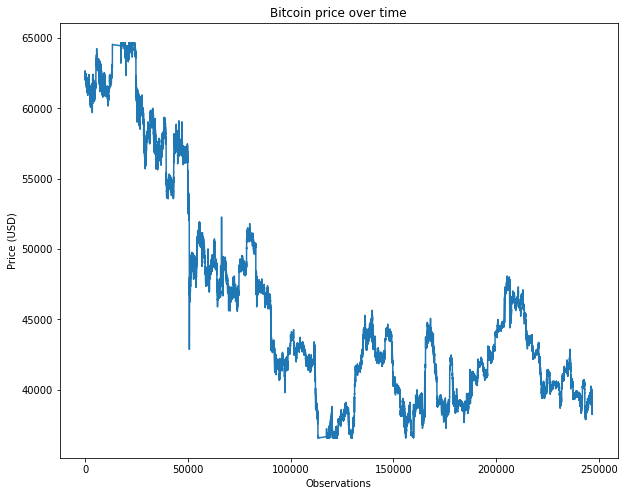

In [3]:
# Increase size of plot in jupyter
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(df['quote_USD_price'])
plt.xlabel("Observations")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show()

## Clean Data
- Drop id column
- Create X df with all predictors except our target price.
- And Y df with target feature ***quote_USD_price***.

In [4]:
# drop _id column
df.drop(columns=['_id'], inplace=True)
# separate data tou X and y
X, y = df.drop(columns=['quote_USD_price']), df['quote_USD_price'].values
X.shape, y.shape

((246791, 29), (246791,))

## Standardising Our Features

Standardisation helps deep learning model training by ensuring
that parameters can exist in the same multi dimensional space

- We will use standardisation for our predictor by
  removing mean and scaling to unit variance.

In [5]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_trans = scaler.fit_transform(X)
y_trans = scaler.fit_transform(y.reshape(-1, 1))

## Split timeSeries
This helper function is used in order to split dataset in time series.

In [6]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X_list, y_list = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X_list.append(seq_x), y_list.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
X_series, y_series = split_sequences(X_trans, y_trans, 120, 15)
print(X_series.shape, y_series.shape)

Traceback (most recent call last):
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug/pydev_jupyter_utils.py", line 69, in attach_to_debugger
    debugger.prepare_to_run(enable_tracing_from_start=False)
TypeError: prepare_to_run() got an unexpected keyword argument 'enable_tracing_from_start'
Failed to connect to target debugger.


(246791, 29) (246791,)


 Check X and y time series:
 - X should start data from 120th element of all data and contain the previous 119 in its time Series
 -

In [10]:
X_series



array([[6.29715400e+04, 6.25611300e+04, 1.63552737e+09, ...,
        4.34826000e+01, 1.31367611e+12, 8.33660422e-04],
       [6.29715400e+04, 6.25800500e+04, 1.63552731e+09, ...,
        4.34826000e+01, 1.31314991e+12, 8.33660422e-04],
       [6.29715400e+04, 6.25911700e+04, 1.63552743e+09, ...,
        4.34826000e+01, 1.31359042e+12, 8.33660422e-04],
       ...,
       [3.87869500e+04, 3.83299400e+04, 1.65135241e+09, ...,
        4.20546000e+01, 8.05082551e+11, 8.00273973e-04],
       [3.87869500e+04, 3.83447900e+04, 1.65135247e+09, ...,
        4.20515000e+01, 8.05023374e+11, 8.00273973e-04],
       [3.87869500e+04, 3.83395400e+04, 1.65135253e+09, ...,
        4.20584000e+01, 8.05059977e+11, 8.00273973e-04]])